# Style Transfer First Steps

This notebook should give a first outlook what style transfer can achieve and show a first model.
What we are wanting to do is to use a pretrained VGG16 model, delete the top layers originally used for classification and use the feature vectors to minimize differences between the two images!


## Loading the model

A pretrained model is stored e.g. here: https://s3.amazonaws.com/cadl/models/vgg16.tfmodel
Let's download this model and store it in Google Drive!

In [1]:
# load libraries
import urllib.request
urllib.request.urlretrieve('https://s3.amazonaws.com/cadl/models/vgg16.tfmodel', 'vgg16.tfmodel')

('vgg16.tfmodel', <http.client.HTTPMessage at 0x7f6e3827ea20>)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from PIL import Image 
import os

In [3]:
# check installed version of tensorflow
tf.__version__

'1.4.1'

In [4]:
# check if running on gpu
tf.test.gpu_device_name()

'/device:GPU:0'

## VGG16 model

Now we define the VGG16 model (taken from the tensorflow introduction series)

In [0]:
class VGG16:
    """
    The VGG16 model is a Deep Neural Network which has already been
    trained for classifying images into 1000 different categories.
    When you create a new instance of this class, the VGG16 model
    will be loaded and can be used immediately without training.
    """

    # Name of the tensor for feeding the input image.
    tensor_name_input_image = "images:0"

    # Names of the tensors for the dropout random-values..
    tensor_name_dropout = 'dropout/random_uniform:0'
    tensor_name_dropout1 = 'dropout_1/random_uniform:0'

    # Names for the convolutional layers in the model for use in Style Transfer.
    layer_names = ['conv1_1/conv1_1', 'conv1_2/conv1_2',
                   'conv2_1/conv2_1', 'conv2_2/conv2_2',
                   'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3',
                   'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3',
                   'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

    def __init__(self):

        # Create a new TensorFlow computational graph.
        self.graph = tf.Graph()

        # Set the new graph as the default.
        with self.graph.as_default():

            # Open the graph-def file for binary reading.
            path = os.path.join(os.getcwd(), 'vgg16.tfmodel')
            with tf.gfile.FastGFile(path, 'rb') as file:
                graph_def = tf.GraphDef()
                graph_def.ParseFromString(file.read())
                tf.import_graph_def(graph_def, name='')

            # Get a reference to the tensor for inputting images to the graph.
            self.input = self.graph.get_tensor_by_name(self.tensor_name_input_image)

            # Get references to the tensors for the commonly used layers.
            self.layer_tensors = [self.graph.get_tensor_by_name(name + ":0") for name in self.layer_names]

    def get_layer_tensors(self, layer_ids):
        """
        Return a list of references to the tensors for the layers with the given id's.
        """

        return [self.layer_tensors[idx] for idx in layer_ids]

    def get_layer_names(self, layer_ids):
        """
        Return a list of names for the layers with the given id's.
        """

        return [self.layer_names[idx] for idx in layer_ids]

    def get_all_layer_names(self, startswith=None):
        """
        Return a list of all the layers (operations) in the graph.
        The list can be filtered for names that start with the given string.
        """

        # Get a list of the names for all layers (operations) in the graph.
        names = [op.name for op in self.graph.get_operations()]

        # Filter the list of names so we only get those starting with
        # the given string.
        if startswith is not None:
            names = [name for name in names if name.startswith(startswith)]

        return names

    def create_feed_dict(self, image):
        """
        Create and return a feed-dict with an image.
        :param image:
            The input image is a 3-dim array which is already decoded.
            The pixels MUST be values between 0 and 255 (float or int).
        :return:
            Dict for feeding to the graph in TensorFlow.
        """

        # Expand 3-dim array to 4-dim by prepending an 'empty' dimension.
        # This is because we are only feeding a single image, but the
        # VGG16 model was built to take multiple images as input.
        image = np.expand_dims(image, axis=0)

        if False:
            # In the original code using this VGG16 model, the random values
            # for the dropout are fixed to 1.0.
            # Experiments suggest that it does not seem to matter for
            # Style Transfer, and this causes an error with a GPU.
            dropout_fix = 1.0

            # Create feed-dict for inputting data to TensorFlow.
            feed_dict = {self.tensor_name_input_image: image,
                         self.tensor_name_dropout: [[dropout_fix]],
                         self.tensor_name_dropout1: [[dropout_fix]]}
        else:
            # Create feed-dict for inputting data to TensorFlow.
            feed_dict = {self.tensor_name_input_image: image}

        return feed_dict

## Helper functions

In [0]:
# load images
def load_image(filename, max_size=None):
    image = Image.open(filename)

    if max_size is not None:
        # Calculate the appropriate rescale-factor for
        # ensuring a max height and width, while keeping
        # the proportion between them.
        factor = max_size / np.max(image.size)
    
        # Scale the image's height and width.
        size = np.array(image.size) * factor

        # The size is now floating-point because it was scaled.
        # But PIL requires the size to be integers.
        size = size.astype(int)

        # Resize the image.
        image = image.resize(size, Image.LANCZOS)

    # Convert to numpy floating-point array.
    return np.float32(image)
  
# save images
def save_image(image, filename):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image-file in jpeg-format.
    with open(filename, 'wb') as file:
        Image.fromarray(image).save(file, 'jpeg')

# plot image
def plot_image_big(image):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)

    # Convert pixels to bytes.
    image = image.astype(np.uint8)

    # Convert to a PIL-image and display it.
    display(Image.fromarray(image))

## Define loss functions

When the content-loss is minimized, it means that the mixed-image has feature activations in the given layers that are very similar to the activations of the content-image. Depending on which layers are selected, this should transfer the contours from the content-image to the mixed-image.

In [0]:
# mean squared error
def mse(a, b):
    return tf.reduce_mean(tf.square(a - b))
  
# loss-function for content image!
def create_content_loss(session, model, content_image, layer_ids):
    """
    Create the loss-function for the content-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model here used is the VGG16-class.
    content_image: Numpy float array with the content-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """
    
    # Create a feed-dict with the content-image.
    feed_dict = model.create_feed_dict(image=content_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Calculate the output values of those layers when
    # feeding the content-image to the model.
    values = session.run(layers, feed_dict=feed_dict)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Initialize an empty list of loss-functions.
        layer_losses = []
    
        # For each layer and its corresponding values
        # for the content-image.
        for value, layer in zip(values, layers):
            # These are the values that are calculated
            # for this layer in the model when inputting
            # the content-image. Wrap it to ensure it
            # is a const - although this may be done
            # automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the layer-values
            # when inputting the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mse(layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss
  
# gram matrix
def gram_matrix(tensor):
    shape = tensor.get_shape()
    
    # Get the number of feature channels for the input tensor,
    # which is assumed to be from a convolutional layer with 4-dim.
    num_channels = int(shape[3])

    # Reshape the tensor so it is a 2-dim matrix. This essentially
    # flattens the contents of each feature-channel.
    matrix = tf.reshape(tensor, shape=[-1, num_channels])
    
    # Calculate the Gram-matrix as the matrix-product of
    # the 2-dim matrix with itself. This calculates the
    # dot-products of all combinations of the feature-channels.
    gram = tf.matmul(tf.transpose(matrix), matrix)

    return gram
  
  
# loss-function for styling image
def create_style_loss(session, model, style_image, layer_ids):
    """
    Create the loss-function for the style-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    style_image: Numpy float array with the style-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """

    # Create a feed-dict with the style-image.
    feed_dict = model.create_feed_dict(image=style_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Construct the TensorFlow-operations for calculating
        # the Gram-matrices for each of the layers.
        gram_layers = [gram_matrix(layer) for layer in layers]

        # Calculate the values of those Gram-matrices when
        # feeding the style-image to the model.
        values = session.run(gram_layers, feed_dict=feed_dict)

        # Initialize an empty list of loss-functions.
        layer_losses = []
    
        # For each Gram-matrix layer and its corresponding values.
        for value, gram_layer in zip(values, gram_layers):
            # These are the Gram-matrix values that are calculated
            # for this layer in the model when inputting the
            # style-image. Wrap it to ensure it is a const,
            # although this may be done automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the Gram-matrix values
            # for the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mse(gram_layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss
  

def create_denoise_loss(model):
    """
    Total Variation Denoising and essentially just shifts the image one pixel 
    in the x- and y-axis, calculates the difference from the original image, 
    takes the absolute value to ensure the difference is a positive number, 
    and sums over all the pixels in the image
    """
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))
    return loss

## Style Transfer Algorithm

In [0]:
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):
    """
    Use gradient descent to find an image that minimizes the
    loss-functions of the content-layers and style-layers. This
    should result in a mixed-image that resembles the contours
    of the content-image, and resembles the colours and textures
    of the style-image.
    
    Parameters:
    content_image: Numpy 3-dim float-array with the content-image.
    style_image: Numpy 3-dim float-array with the style-image.
    content_layer_ids: List of integers identifying the content-layers.
    style_layer_ids: List of integers identifying the style-layers.
    weight_content: Weight for the content-loss-function.
    weight_style: Weight for the style-loss-function.
    weight_denoise: Weight for the denoising-loss-function.
    num_iterations: Number of optimization iterations to perform.
    step_size: Step-size for the gradient in each iteration.
    """

    # Create an instance of the VGG16-model. This is done
    # in each call of this function, because we will add
    # operations to the graph so it can grow very large
    # and run out of RAM if we keep using the same instance.
    model = VGG16()

    # Create a TensorFlow-session.
    session = tf.InteractiveSession(graph=model.graph)

    # Print the names of the content-layers.
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()

    # Print the names of the style-layers.
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()

    # Create the loss-function for the content-layers and -image.
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)

    # Create the loss-function for the style-layers and -image.
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)    

    # Create the loss-function for the denoising of the mixed-image.
    loss_denoise = create_denoise_loss(model)

    # Create TensorFlow variables for adjusting the values of
    # the loss-functions. This is explained below.
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')

    # Initialize the adjustment values for the loss-functions.
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])

    # Create TensorFlow operations for updating the adjustment values.
    # These are basically just the reciprocal values of the
    # loss-functions, with a small value 1e-10 added to avoid the
    # possibility of division by zero.
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))

    # This is the weighted loss-function that we will minimize
    # below in order to generate the mixed-image.
    # Because we multiply the loss-values with their reciprocal
    # adjustment values, we can use relative weights for the
    # loss-functions that are easier to select, as they are
    # independent of the exact choice of style- and content-layers.
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise

    # Use TensorFlow to get the mathematical function for the
    # gradient of the combined loss-function with regard to
    # the input image.
    gradient = tf.gradients(loss_combined, model.input)

    # List of tensors that we will run in each optimization iteration.
    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]

    # The mixed-image is initialized with random noise.
    # It is the same size as the content-image.
    mixed_image = np.random.rand(*content_image.shape) + 128

    for i in range(num_iterations):
        # Create a feed-dict with the mixed-image.
        feed_dict = model.create_feed_dict(image=mixed_image)

        # Use TensorFlow to calculate the value of the
        # gradient, as well as updating the adjustment values.
        grad, adj_content_val, adj_style_val, adj_denoise_val \
        = session.run(run_list, feed_dict=feed_dict)

        # Reduce the dimensionality of the gradient.
        grad = np.squeeze(grad)

        # Scale the step-size according to the gradient-values.
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        mixed_image -= grad * step_size_scaled

        # Ensure the image has valid pixel-values between 0 and 255.
        mixed_image = np.clip(mixed_image, 0.0, 255.0)

        # Print a little progress-indicator.
        print(". ", end="")

        # Display status once every 10 iterations, and the last.
        if (i % 50 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # Print adjustment weights for loss-functions.
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

            # Plot the content-, style- and mixed-images.
            plot_image_big(mixed_image)
            
    print()
    print("Final image:")
    plot_image_big(mixed_image)

    # Close the TensorFlow session to release its resources.
    session.close()
    
    # Return the mixed-image.
    return mixed_image

## Examples

In [17]:
urllib.request.urlretrieve('https://images-na.ssl-images-amazon.com/images/I/61V6vhPwfQL._SL1000_.jpg', 'garten.jpg')
urllib.request.urlretrieve('https://images-na.ssl-images-amazon.com/images/I/81n%2ByVC8ajL._SY492_.jpg', 'vg.jpg')

('vg.jpg', <http.client.HTTPMessage at 0x7f6df9c89390>)

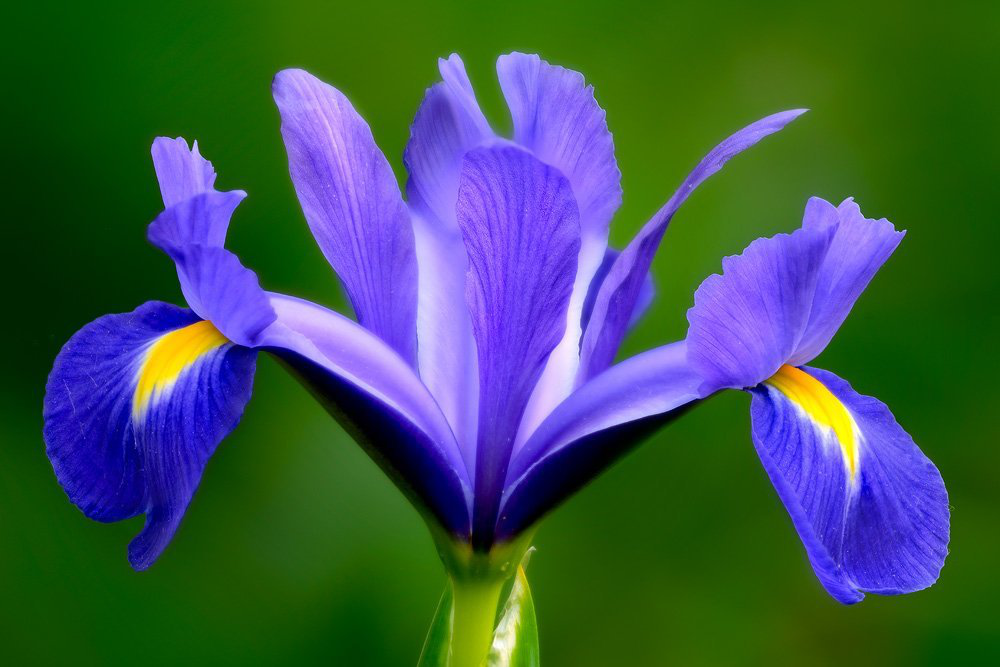

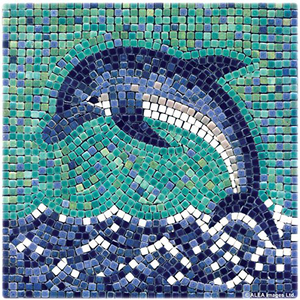

In [18]:
content_image = load_image('garten.jpg', max_size=None)
style_image = load_image('vg.jpg', max_size=300)
plot_image_big(content_image)
plot_image_big(style_image)

In [0]:
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=[4],
                     style_layer_ids=list(range(13)),
                     weight_content=1.5,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=1000,
                     step_size=10.0)

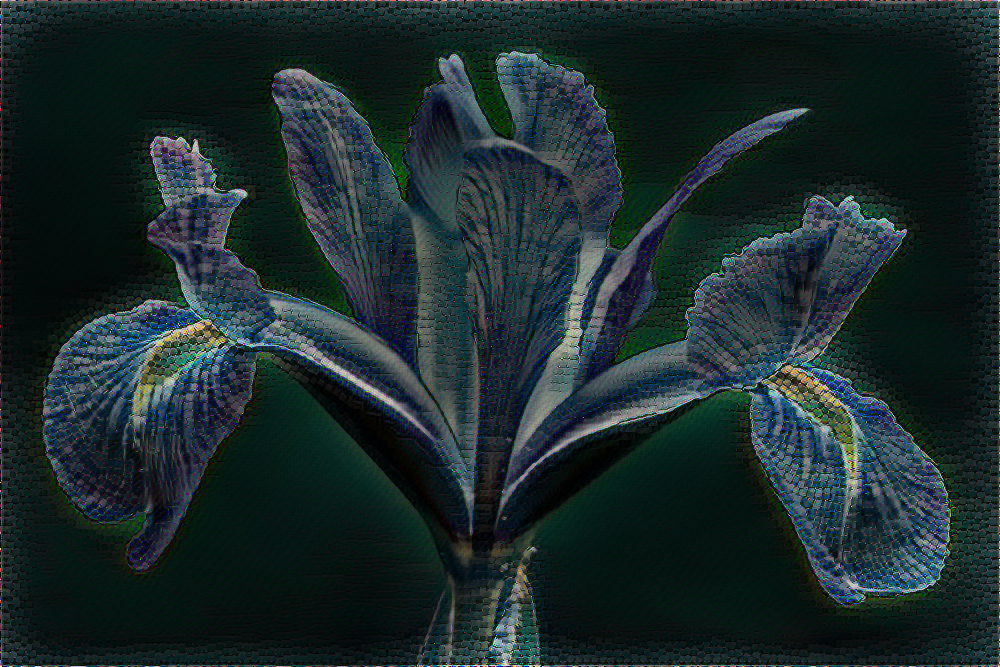

In [20]:
plot_image_big(img)

Yay! Pretty iris